# Import

In [53]:
from datetime import datetime, timedelta
from statistics import mean
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import psycopg2
import calendar

# DataBase Connection

In [54]:
# SoftTouch Lenses complete database
conn = psycopg2.connect(
    host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='softtouchlenses_4e0b7c925f8444429457581f35678aea',
    password='softtouchlenses_4e0b7c925f8444429457581f35678aea_password',
    database='softtouchlenses_4e0b7c925f8444429457581f35678aea_db'
)

# Extract and Derive Data

In [55]:
query1 = """select
created_at::date as created,
id as id,
customer_id as user_id,
source_name as ordered_via,
total_price as order_amount,
CASE
        WHEN cancelled_at IS NOT NULL THEN 'Cancelled'
        ELSE 'Delivered'
    END as order_status
from orders;"""

query2 = """select
order_id,
name as product_name,
quantity from
order_line_item;"""

In [56]:
e=pd.read_sql(query1,conn)
e.columns = ["created", "order_id", "user_id", "order_channel", "order_amount", "order_status"]
e['created'] = pd.to_datetime(e['created'])
#OrderCount, ASP, AOV, GMV, Acquistion Ratio, Repeat Rate

f = pd.read_sql(query2,conn)
f.columns = ["order_id", "product_name", "quantity"]
# f['created'] = pd.to_datetime(f['created'])
OrderSKUMap=f.groupby('order_id').agg(
        SKUs=pd.NamedAgg(column='product_name', aggfunc= 'nunique'),
        Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
    ).reset_index()

# Set Data Columns
e['OrderDate']=e['created'].dt.date
e['OrderDate']=pd.to_datetime(e['OrderDate'])
#Delta Columns
e['DeltaDaysinOrders']=(e.groupby('user_id').OrderDate.shift() - e.OrderDate).dt.days.abs()
e['DeltaOrderValues']=(e.groupby('user_id').order_amount.shift() - e.order_amount)
#Analysis Parameters


x1=e.groupby('user_id').agg(
        LastDate=pd.NamedAgg(column='OrderDate', aggfunc= 'max'),
        FirstDate=pd.NamedAgg(column='OrderDate', aggfunc='min'),

    ).reset_index()


e2=e.merge(x1[['user_id','LastDate','FirstDate']], left_on='user_id', right_on='user_id')
e2=e2.merge(OrderSKUMap, left_on='order_id', right_on='order_id', how='left')

e2['TrxnRank'] = e2.groupby('user_id')['OrderDate'].rank(method='first')
# e2=e2[e2['OrderDate']>='2022-01-01']
# e2=e2[e2['OrderDate']<='2022-12-31']


#fetch metrices

e2['New']=0
e2.loc[e2['TrxnRank']==1,'New']=1
e2['Repeat']=0
e2.loc[e2['TrxnRank']>1,'Repeat']=1
e2_copy = e2.copy()
e2 = e2[e2["New"] == 1]

# e2['order_id']=e2['order_id_x']
y2=e2.groupby('OrderDate').agg(
        OrderCounts=pd.NamedAgg(column='order_id', aggfunc= 'count'),
        TotalOrderValue=pd.NamedAgg(column='order_amount', aggfunc='sum'),
        AOV=pd.NamedAgg(column='order_amount', aggfunc='mean'),
    Quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
SKUCount=pd.NamedAgg(column='SKUs', aggfunc='sum'),

    ).reset_index()

cancelled_orders = e2[e2['order_status'] == 'Cancelled'].groupby('OrderDate').agg(
    CancellationCount=pd.NamedAgg(column='order_id', aggfunc='count')
).reset_index()

delivered_orders = e2[e2['order_status'] == 'Delivered'].groupby('OrderDate').agg(
    DeliveryCount=pd.NamedAgg(column='order_id', aggfunc='count')
).reset_index()

y3=e2.groupby(['OrderDate', "user_id"]).agg(
        TotalOrderValue=pd.NamedAgg(column='order_amount', aggfunc='sum'),
    Quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
SKUCount=pd.NamedAgg(column='SKUs', aggfunc='sum'),
).reset_index()
y3['UserRank']=y3.groupby('user_id')['OrderDate'].rank(method='first')
y3 = y3.groupby('OrderDate').agg(
    NewUserCount=pd.NamedAgg(column='UserRank', aggfunc=lambda x: (x == 1.0).sum())
)

y2 = y2.merge(cancelled_orders, on='OrderDate', how='left')
y2 = y2.merge(delivered_orders, on='OrderDate', how='left')
y2['CancellationCount'].fillna(0, inplace=True)
y2['DeliveryCount'].fillna(0, inplace=True)

y2=y2.merge(y3, left_on='OrderDate', right_on='OrderDate')

ordered_via_values = e2['order_channel'].unique()
for ordered_via in ordered_via_values:
    y2[f'Channel_{ordered_via}'] = 0
for ordered_via in ordered_via_values:
    orders_by_channel = e2[e2['order_channel'] == ordered_via].groupby('OrderDate').size()
    y2[f'Channel_{ordered_via}'] = y2['OrderDate'].map(orders_by_channel).fillna(0)

# y2['NewOrderRatio']=y2['NewTrxns']/y2['OrderCounts']
# y2['RepeatOrderRatio']=y2['RepearTrxns']/y2['OrderCounts']
y2['UnitsperOrder']=y2['Quantity']/y2['OrderCounts']
y2['SKUsperOrder']=y2['SKUCount']/y2['OrderCounts']
y2['ASP']=y2['TotalOrderValue']/y2['Quantity']
y2['CancellationRate']=y2['CancellationCount']/y2['OrderCounts']
# y2["RepeatUserCount"] = y2["ActiveUsersCounts"] - y2["NewUserCount"]

channel_metrics=[]
for ordered_via in ordered_via_values:
    metric = f'Channel_{ordered_via}'
    channel_metrics.append(metric)
y2.columns = ["Order_Date", "Order_Counts", "Total_Order_Value", "AOV", "Total_Quantity", "Products_Count", "Cancelled_Order_Counts", "Delivered_Orders_Counts", "New_User_Counts"] + channel_metrics + ["No_Units_per_Order", "No_Products_per_Order", "ASP", "Calcellation_Rate_(in %)"]

C:\Users\CEPL\AppData\Local\Temp\ipykernel_588\3352494058.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  e=pd.read_sql(query1,conn)
C:\Users\CEPL\AppData\Local\Temp\ipykernel_588\3352494058.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  f = pd.read_sql(query2,conn)


In [57]:
y2

,Order_Date,Order_Counts,Total_Order_Value,AOV,Total_Quantity,Products_Count,Cancelled_Order_Counts,Delivered_Orders_Counts,New_User_Counts,Channel_web,Channel_1183497,No_Units_per_Order,No_Products_per_Order,ASP,Calcellation_Rate_(in %)
0,2021-08-17,1,1000.0,1000.000000,1,1,1.0,0.0,1,1,0.0,1.000000,1.000000,1000.000000,1.000000
1,2021-08-19,3,2098.0,699.333333,3,3,1.0,2.0,3,3,0.0,1.000000,1.000000,699.333333,0.333333
2,2021-08-20,2,2899.0,1449.500000,4,3,0.0,2.0,2,2,0.0,2.000000,1.500000,724.750000,0.000000
3,2021-08-22,3,4154.0,1384.666667,4,4,0.0,3.0,3,3,0.0,1.333333,1.333333,1038.500000,0.000000
4,2021-08-23,1,1885.0,1885.000000,1,1,0.0,1.0,1,1,0.0,1.000000,1.000000,1885.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,2023-11-27,3,5528.0,1842.666667,5,3,0.0,3.0,3,3,0.0,1.666667,1.000000,1105.600000,0.000000
683,2023-11-28,1,2190.0,2190.000000,1,1,0.0,1.0,1,1,0.0,1.000000,1.000000,2190.000000,0.000000
684,2023-11-29,2,6650.0,3325.000000,6,2,0.0,2.0,2,2,0.0,3.000000,1.000000,1108.333333,0.000000
685,2023-11-30,5,10837.0,2167.400000,6,5,0.0,5.0,5,5,0.0,1.200000,1.000000,1806.166667,0.000000


# Acquisition Seasonality

In [58]:
overall_metrics = ["Order_Date", "Order_Counts", "Total_Order_Value", "AOV", "ASP", "No_Products_per_Order", "No_Units_per_Order", "Cancelled_Order_Counts", "Calcellation_Rate_(in %)"] + channel_metrics
working_df = y2[overall_metrics]

In [59]:
def day_of_week(df, param):
    col_name = f"Average_{param}"
    df_1 = df[["Order_Date", param]]
    df_1.columns = ["Date", "Value"]
    df_1['DayOfWeek'] = df_1['Date'].dt.strftime('%A')
    custom_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    df_1['DayOfWeek'] = pd.Categorical(df_1['DayOfWeek'], categories=custom_order, ordered=True)
    result = df_1.groupby('DayOfWeek')['Value'].mean().reset_index()
    result.columns = ["DayOfWeek", col_name]
    m = result[col_name].mean()
    result["Seasonality_Index"] = (result[col_name] - m)*100/m
    x = f"Average_Weekly_{param}"
    result.columns = ["Day_of_the_Week", x, "Seasonality_Index_(in %)"]
    return result

def day_of_month(df, param):
    col_name = f"Average_{param}"
    df_1 = df[["Order_Date", param]]
    df_1.columns = ["Date", "Value"]
    df_1['DayOfMonth'] = df_1['Date'].dt.day
    result = df_1.groupby('DayOfMonth')['Value'].mean().reset_index()
    result.columns = ["DayOfMonth", col_name]
    m = result[col_name].mean()
    result["Seasonality_Index"] = (result[col_name] - m)*100/m
    x = f"Average_Monthly_{param}"
    result.columns = ["Day_of_the_Month", x, "Seasonality_Index_(in %)"]
    return result

def month_of_year(df, param):
    col_name = f"Average_{param}"
    df_1 = df[["Order_Date", param]]
    df_1.columns = ["Date", "Value"]
    df_1['Month'] = df_1['Date'].dt.strftime('%B')
    custom_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    df_1['Month'] = pd.Categorical(df_1['Month'], categories=custom_order, ordered=True)
    result = df_1.groupby('Month')['Value'].mean().reset_index()
    result.columns = ["Month", col_name]
    m = result[col_name].mean()
    result["Seasonality_Index"] = (result[col_name] - m)*100/m
    x = f"Average_Yearly_{param}"
    result.columns = ["Month_of_the_Year", x, "Seasonality_Index_(in %)"]
    return result

In [60]:
x = day_of_week(working_df, "Order_Counts")

C:\Users\CEPL\AppData\Local\Temp\ipykernel_588\3068450471.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['DayOfWeek'] = df_1['Date'].dt.strftime('%A')
C:\Users\CEPL\AppData\Local\Temp\ipykernel_588\3068450471.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['DayOfWeek'] = pd.Categorical(df_1['DayOfWeek'], categories=custom_order, ordered=True)
C:\Users\CEPL\AppData\Local\Temp\ipykernel_588\3068450471.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to Tr

In [61]:
x

,Day_of_the_Week,Average_Weekly_Order_Counts,Seasonality_Index_(in %)
0,Sunday,2.750000,-0.846862
1,Monday,2.898990,4.525071
2,Tuesday,2.880000,3.840377
3,Wednesday,2.778947,0.196855
4,Thursday,2.495146,-10.035811
5,Friday,2.747253,-0.945916
6,Saturday,2.864078,3.266287


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


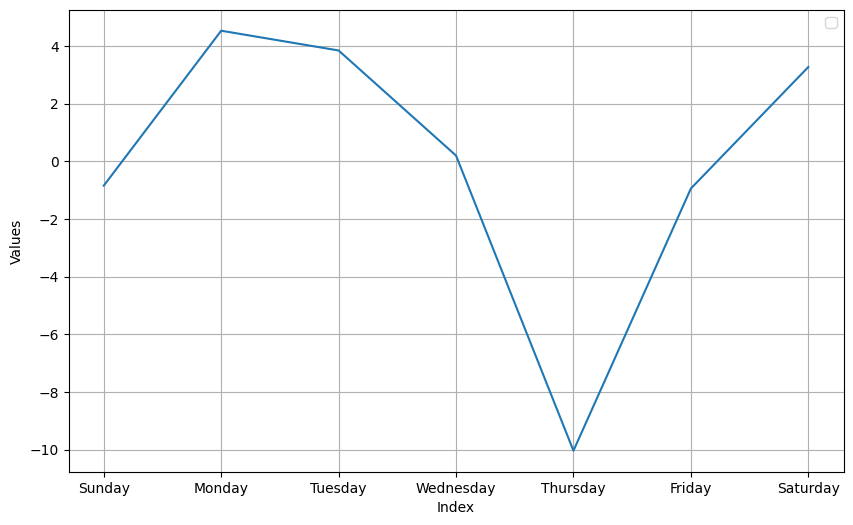

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(x.iloc[:, 0], x.iloc[:, 2])
plt.xlabel('Index')
plt.ylabel('Values')
plt.grid(True)
plt.legend()
plt.show()

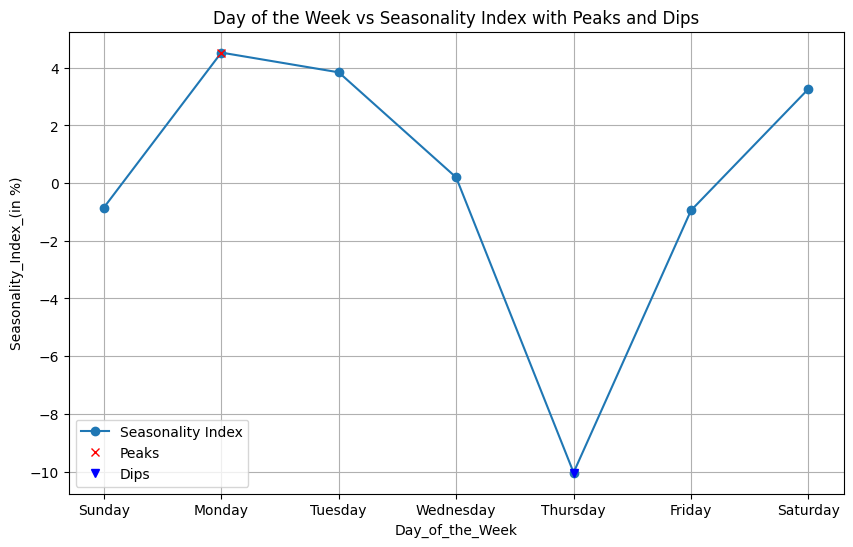

In [63]:
days_of_week = x[x.columns.tolist()[0]].tolist()
seasonality_index = x[x.columns.tolist()[2]].tolist()

peaks, _ = find_peaks(seasonality_index, distance=1)
dips, _ = find_peaks(-np.array(seasonality_index), distance=1)

plt.figure(figsize=(10, 6))
plt.plot(days_of_week, seasonality_index, marker='o', label='Seasonality Index')
plt.plot(np.array(days_of_week)[peaks], np.array(seasonality_index)[peaks], "rx", label="Peaks")
plt.plot(np.array(days_of_week)[dips], np.array(seasonality_index)[dips], "bv", label="Dips")

plt.title(f'Day of the Week vs Seasonality Index with Peaks and Dips')
plt.xlabel(x.columns.tolist()[0])
plt.ylabel(x.columns.tolist()[2])
plt.legend()
plt.grid(True)
plt.show()

In [64]:
seasonality_cycles = ["Weekly", "Monthly", "Yearly"]

In [65]:
metrics = []
cycle = []
peak_counts = []
dip_counts = []
target_metrics = overall_metrics[1:]

for i in range (len(target_metrics)):
    for j in range (len(seasonality_cycles)):
        metric = target_metrics[i]
        current_cycle = seasonality_cycles[j]
        
        if current_cycle == "Weekly":
            dummy_df = day_of_week(working_df, metric)
        elif current_cycle == "Monthly":
            dummy_df = day_of_month(working_df, metric)
        elif current_cycle == "Yearly":
            dummy_df = month_of_year(working_df, metric)

        seasonality_index = dummy_df.iloc[:, 2].tolist()
        peaks, _ = find_peaks(seasonality_index, distance=1)
        dips, _ = find_peaks(-np.array(seasonality_index), distance=1)

        peak_count = len(peaks)
        dip_count = len(dips)
        
        metrics.append(metric)
        cycle.append(current_cycle)
        peak_counts.append(peak_count)
        dip_counts.append(dip_count)

view1_peak_dip = pd.DataFrame({"Mertics": metrics, "Seasonality Cycle": cycle, "Peak Count": peak_counts, "Dip Counts": dip_counts})

C:\Users\CEPL\AppData\Local\Temp\ipykernel_588\3068450471.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['DayOfWeek'] = df_1['Date'].dt.strftime('%A')
C:\Users\CEPL\AppData\Local\Temp\ipykernel_588\3068450471.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['DayOfWeek'] = pd.Categorical(df_1['DayOfWeek'], categories=custom_order, ordered=True)
C:\Users\CEPL\AppData\Local\Temp\ipykernel_588\3068450471.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to Tr

In [66]:
view1_peak_dip

,Mertics,Seasonality Cycle,Peak Count,Dip Counts
0,Order_Counts,Weekly,1,1
1,Order_Counts,Monthly,11,10
2,Order_Counts,Yearly,3,2
3,Total_Order_Value,Weekly,1,2
4,Total_Order_Value,Monthly,10,9
5,Total_Order_Value,Yearly,2,1
6,AOV,Weekly,2,2
7,AOV,Monthly,10,11
8,AOV,Yearly,4,3
9,ASP,Weekly,3,2


In [67]:
metrics = []
cycle = []
min_values = []
max_values = []
ratios = []
target_metrics = overall_metrics[1:]

for i in range (len(target_metrics)):
    for j in range (len(seasonality_cycles)):
        metric = target_metrics[i]
        print(metric)
        current_cycle = seasonality_cycles[j]
        
        if current_cycle == "Weekly":
            dummy_df = day_of_week(working_df, metric)
        elif current_cycle == "Monthly":
            dummy_df = day_of_month(working_df, metric)
        elif current_cycle == "Yearly":
            dummy_df = month_of_year(working_df, metric)

        average_values = dummy_df.iloc[:, 1].tolist()
        min_value = min(average_values)
        max_value = max(average_values)
        if min_value == 0:
            average_values_updated = [x for x in average_values if x != 0]
            min_value = min(average_values_updated)
        ratio = max_value/min_value
        
        metrics.append(metric)
        cycle.append(current_cycle)
        min_values.append(min_value)
        max_values.append(max_value)
        ratios.append(ratio)

view2_peak_dip = pd.DataFrame({"Mertics": metrics, "Seasonality Cycle": cycle, "Dip Value": min_values, "Peak Value": max_values, "Variation Ratio": ratios})

C:\Users\CEPL\AppData\Local\Temp\ipykernel_588\3068450471.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['DayOfWeek'] = df_1['Date'].dt.strftime('%A')
C:\Users\CEPL\AppData\Local\Temp\ipykernel_588\3068450471.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['DayOfWeek'] = pd.Categorical(df_1['DayOfWeek'], categories=custom_order, ordered=True)
C:\Users\CEPL\AppData\Local\Temp\ipykernel_588\3068450471.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to Tr

Order_Counts
Order_Counts
Order_Counts
Total_Order_Value
Total_Order_Value
Total_Order_Value
AOV
AOV
AOV
ASP
ASP
ASP
No_Products_per_Order
No_Products_per_Order
No_Products_per_Order
No_Units_per_Order
No_Units_per_Order
No_Units_per_Order
Cancelled_Order_Counts
Cancelled_Order_Counts
Cancelled_Order_Counts
Calcellation_Rate_(in %)
Calcellation_Rate_(in %)
Calcellation_Rate_(in %)
Channel_web
Channel_web
Channel_web
Channel_1183497
Channel_1183497
Channel_1183497


C:\Users\CEPL\AppData\Local\Temp\ipykernel_588\3068450471.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['DayOfMonth'] = df_1['Date'].dt.day
C:\Users\CEPL\AppData\Local\Temp\ipykernel_588\3068450471.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['Month'] = df_1['Date'].dt.strftime('%B')
C:\Users\CEPL\AppData\Local\Temp\ipykernel_588\3068450471.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [68]:
view2_peak_dip.round(2)

,Mertics,Seasonality Cycle,Dip Value,Peak Value,Variation Ratio
0,Order_Counts,Weekly,2.50,2.90,1.16
1,Order_Counts,Monthly,2.11,3.47,1.65
2,Order_Counts,Yearly,1.86,3.78,2.03
3,Total_Order_Value,Weekly,3942.16,4677.24,1.19
4,Total_Order_Value,Monthly,2999.32,5761.12,1.92
5,Total_Order_Value,Yearly,2697.58,5948.80,2.21
6,AOV,Weekly,1483.60,1631.47,1.10
7,AOV,Monthly,1226.01,2092.43,1.71
8,AOV,Yearly,1435.39,1783.07,1.24
9,ASP,Weekly,1234.16,1305.76,1.06


In [69]:
view2_peak_dip["Variation Ratio"].nlargest(5)

22    8.486111
19    4.952381
29    3.020408
23    2.632347
5     2.205235
Name: Variation Ratio, dtype: float64

In [70]:
metrics = []
cycle = []
above_average_counts = []
below_average_counts = []
target_metrics = overall_metrics[1:]

for i in range (len(target_metrics)):
    for j in range (len(seasonality_cycles)):
        metric = target_metrics[i]
        current_cycle = seasonality_cycles[j]
        
        if current_cycle == "Weekly":
            dummy_df = day_of_week(working_df, metric)
        elif current_cycle == "Monthly":
            dummy_df = day_of_month(working_df, metric)
        elif current_cycle == "Yearly":
            dummy_df = month_of_year(working_df, metric)

        seasonality_index = dummy_df.iloc[:, 2].tolist()
        m = mean(seasonality_index)

        above_average = [x for x in seasonality_index if x >= m]
        below_average = [x for x in seasonality_index if x < m]
        
        above_average_count = len(above_average)
        below_average_count = len(below_average)
        
        metrics.append(metric)
        cycle.append(current_cycle)
        above_average_counts.append(above_average_count)
        below_average_counts.append(below_average_count)

view3_peak_dip = pd.DataFrame({"Mertics": metrics, "Seasonality Cycle": cycle, "Above Average Count": above_average_counts, "Below Average Count": below_average_counts})
view3_peak_dip["Above Average Counts Percentage"] = (view3_peak_dip["Above Average Count"] * 100) / (view3_peak_dip["Above Average Count"] + view3_peak_dip["Below Average Count"])
view3_peak_dip["Below Average Counts Percentage"] = (view3_peak_dip["Below Average Count"] * 100) / (view3_peak_dip["Above Average Count"] + view3_peak_dip["Below Average Count"])

C:\Users\CEPL\AppData\Local\Temp\ipykernel_588\3068450471.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['DayOfWeek'] = df_1['Date'].dt.strftime('%A')
C:\Users\CEPL\AppData\Local\Temp\ipykernel_588\3068450471.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['DayOfWeek'] = pd.Categorical(df_1['DayOfWeek'], categories=custom_order, ordered=True)
C:\Users\CEPL\AppData\Local\Temp\ipykernel_588\3068450471.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to Tr

In [71]:
view3_peak_dip.round(2)

,Mertics,Seasonality Cycle,Above Average Count,Below Average Count,Above Average Counts Percentage,Below Average Counts Percentage
0,Order_Counts,Weekly,4,3,57.14,42.86
1,Order_Counts,Monthly,14,17,45.16,54.84
2,Order_Counts,Yearly,5,7,41.67,58.33
3,Total_Order_Value,Weekly,5,2,71.43,28.57
4,Total_Order_Value,Monthly,12,19,38.71,61.29
5,Total_Order_Value,Yearly,6,6,50.00,50.00
6,AOV,Weekly,4,3,57.14,42.86
7,AOV,Monthly,14,17,45.16,54.84
8,AOV,Yearly,5,7,41.67,58.33
9,ASP,Weekly,3,4,42.86,57.14


# Number of Days for New to Repeat Conversion

In [72]:
gap_new_to_repeat = e2_copy.copy()
gap_new_to_repeat["Gap_between_New_to_Repeat_Trxn_Days"] = -1
for i in range (len(gap_new_to_repeat[gap_new_to_repeat["TrxnRank"] == 2])):
    # if gap_new_to_repeat["TrxnRank"][i] == 2:
    u_id = gap_new_to_repeat["user_id"][i]
    date = gap_new_to_repeat["OrderDate"][i]
    del_days = date - gap_new_to_repeat[(gap_new_to_repeat["user_id"] == u_id) & (gap_new_to_repeat["TrxnRank"] == 1)]["OrderDate"]
    idx = gap_new_to_repeat[(gap_new_to_repeat["user_id"] == u_id) & (gap_new_to_repeat["TrxnRank"] == 1)].index.values[0]
    # print(e2.iloc[idx, 16])
    gap_new_to_repeat.at[idx, "Gap_between_New_to_Repeat_Trxn_Days"] = int(del_days.to_list()[0].days)
    # print(e2.iloc[idx, 16])
gap_new_to_repeat.insert(17, "New_To_Repeat_Conversion_Month", "")

In [73]:
gap_new_to_repeat

,created,order_id,user_id,order_channel,order_amount,order_status,OrderDate,DeltaDaysinOrders,DeltaOrderValues,LastDate,FirstDate,SKUs,Quantity,TrxnRank,New,Repeat,Gap_between_New_to_Repeat_Trxn_Days,New_To_Repeat_Conversion_Month
0,2023-10-16,5131895963822,6339617063086,web,2998.0,Delivered,2023-10-16,NaN,NaN,2023-10-16,2023-02-20,2,2,3.0,0,1,-1,
1,2023-06-26,5002821271726,6339617063086,web,2724.0,Delivered,2023-06-26,112.0,274.0,2023-10-16,2023-02-20,2,2,2.0,0,1,-1,
2,2023-02-20,4845516587182,6339617063086,web,2674.0,Delivered,2023-02-20,126.0,50.0,2023-10-16,2023-02-20,2,2,1.0,1,0,0,
3,2023-09-20,5103650734254,6570528964782,web,2800.0,Delivered,2023-09-20,NaN,NaN,2023-09-20,2023-09-20,1,1,1.0,1,0,0,
4,2023-11-25,5197214744750,6729164030126,web,1300.0,Delivered,2023-11-25,NaN,NaN,2023-11-25,2023-11-25,2,2,1.0,1,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458,2021-08-20,3972209148078,5430117630126,web,1500.0,Delivered,2021-08-20,NaN,NaN,2021-08-20,2021-08-20,2,3,1.0,1,0,-1,
2459,2021-08-20,3970425356462,5427174932654,web,1399.0,Delivered,2021-08-20,NaN,NaN,2021-08-20,2021-08-20,1,1,1.0,1,0,-1,
2460,2021-08-19,3969315209390,5426204672174,web,899.0,Delivered,2021-08-19,NaN,NaN,2021-08-19,2021-08-19,1,1,1.0,1,0,-1,
2461,2021-08-19,3969073283246,5425893015726,web,599.0,Delivered,2021-08-19,NaN,NaN,2021-08-19,2021-08-19,1,1,1.0,1,0,-1,


In [74]:
for i in range (len(gap_new_to_repeat)):
    if gap_new_to_repeat.iloc[i, 16] > -1 and gap_new_to_repeat.iloc[i, 16] <=30:
        gap_new_to_repeat.iloc[i, 17] = "1 Month"
    elif gap_new_to_repeat.iloc[i, 16] > 30 and gap_new_to_repeat.iloc[i, 16] <=90:
        gap_new_to_repeat.iloc[i, 17] = "3 Month"
    elif gap_new_to_repeat.iloc[i, 16] > 90 and gap_new_to_repeat.iloc[i, 16] <=180:
        gap_new_to_repeat.iloc[i, 17] = "6 Month"
    elif gap_new_to_repeat.iloc[i, 16] >180:
        gap_new_to_repeat.iloc[i, 17] = "6+ Month"

In [75]:
gap_new_to_repeat[gap_new_to_repeat["Repeat"] == 1]

,created,order_id,user_id,order_channel,order_amount,order_status,OrderDate,DeltaDaysinOrders,DeltaOrderValues,LastDate,FirstDate,SKUs,Quantity,TrxnRank,New,Repeat,Gap_between_New_to_Repeat_Trxn_Days,New_To_Repeat_Conversion_Month
0,2023-10-16,5131895963822,6339617063086,web,2998.0,Delivered,2023-10-16,NaN,NaN,2023-10-16,2023-02-20,2,2,3.0,0,1,-1,
1,2023-06-26,5002821271726,6339617063086,web,2724.0,Delivered,2023-06-26,112.0,274.0,2023-10-16,2023-02-20,2,2,2.0,0,1,-1,
12,2023-11-23,5191998144686,6302798282926,web,1000.0,Delivered,2023-11-23,NaN,NaN,2023-11-23,2023-02-02,1,1,2.0,0,1,-1,
19,2023-11-23,5191565738158,6713428639918,web,544.0,Delivered,2023-11-23,NaN,NaN,2023-11-23,2023-11-18,1,1,2.0,0,1,-1,
24,2023-11-18,5183195709614,5744561455278,web,1000.0,Delivered,2023-11-18,NaN,NaN,2023-11-18,2022-01-15,1,1,2.0,0,1,-1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,2021-09-29,4048382034094,5472745554094,web,2100.0,Delivered,2021-09-29,NaN,NaN,2021-09-29,2021-09-14,1,1,2.0,0,1,-1,
2422,2021-09-28,4046883389614,5507732766894,web,899.0,Delivered,2021-09-28,0.0,0.0,2021-09-28,2021-09-28,1,1,2.0,0,1,-1,
2445,2021-09-08,4010241097902,5467268743342,web,1100.0,Delivered,2021-09-08,0.0,0.0,2021-09-08,2021-09-08,1,1,2.0,0,1,-1,
2453,2021-08-24,3979108057262,5437782786222,web,800.0,Cancelled,2021-08-24,0.0,0.0,2021-08-24,2021-08-24,1,1,2.0,0,1,-1,


In [76]:
gap_new_to_repeat_days = gap_new_to_repeat[gap_new_to_repeat["Gap_between_New_to_Repeat_Trxn_Days"] != -1][["Gap_between_New_to_Repeat_Trxn_Days"]]

In [77]:
gap_new_to_repeat_days

,Gap_between_New_to_Repeat_Trxn_Days
2,0
3,0
4,0
5,0
6,0
...,...
313,0
317,0
318,0
319,0


In [78]:
data = gap_new_to_repeat_days['Gap_between_New_to_Repeat_Trxn_Days']
counts, bin_edges = np.histogram(data, bins=10)
histogram_table = pd.DataFrame({'Number of Days Between First and Second Purchases': bin_edges[:-1], 'Customer Counts': counts})
histogram_table

,Number of Days Between First and Second Purchases,Customer Counts
0,0.0,178
1,5.0,1
2,10.0,1
3,15.0,0
4,20.0,0
5,25.0,0
6,30.0,1
7,35.0,0
8,40.0,0
9,45.0,1


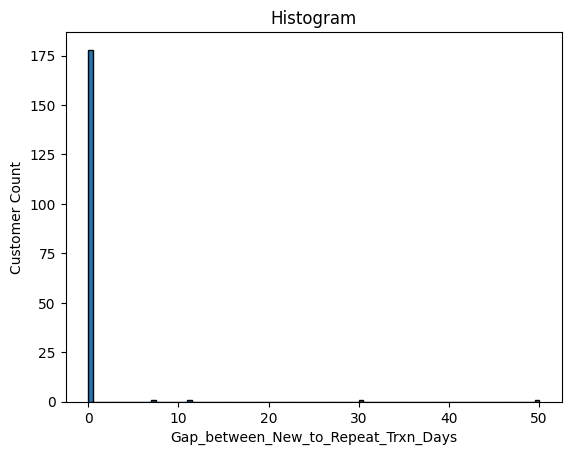

In [79]:
plt.hist(gap_new_to_repeat_days['Gap_between_New_to_Repeat_Trxn_Days'], bins=100, edgecolor='black')
plt.xlabel('Gap_between_New_to_Repeat_Trxn_Days')
plt.ylabel('Customer Count')
plt.title('Histogram')
plt.show()

In [80]:
gap_new_to_repeat_days['Buckets'] = pd.cut(gap_new_to_repeat_days['Gap_between_New_to_Repeat_Trxn_Days'], bins=10, precision=0, include_lowest=False)
decile_table = gap_new_to_repeat_days['Buckets'].value_counts().reset_index()#.sort_values(by = "count", ascending = False)
decile_table.set_index("Buckets", inplace = True)
decile_table = decile_table.sort_values(by="Buckets")

labels = decile_table.index.tolist()
user_counts = decile_table["count"].tolist()
bin_df = pd.DataFrame({'Days Gap Between Transactions (Lower Limit)': [label.left for label in labels],
                       'Days Gap Between Transactions (Upper Limit)': [label.right for label in labels],
                       'Customer Count': user_counts})
bin_df[['Days Gap Between Transactions (Lower Limit)', 'Days Gap Between Transactions (Upper Limit)']] = bin_df[['Days Gap Between Transactions (Lower Limit)', 'Days Gap Between Transactions (Upper Limit)']].apply(lambda x: x.clip(lower=0))
bin_df["No of Days Gap Between Transactions"] = bin_df[["Days Gap Between Transactions (Lower Limit)", "Days Gap Between Transactions (Upper Limit)"]].astype("str").apply("-".join, axis=1)

for i in range(len(bin_df)):
    x = str(bin_df.iloc[i, 3])
    a = (x.split("-")[0])[:-2]
    b = (x.split("-")[1])[:-2]
    x = a + " - " + b + " Days"
    bin_df.iloc[i, 3] = x
bin_df = bin_df[["No of Days Gap Between Transactions", "Customer Count"]]

In [81]:
bin_df = bin_df.T
bin_df.columns = bin_df.iloc[0]
bin_df = bin_df.iloc[1:]
bin_df

No of Days Gap Between Transactions,- 0 Days,5 - 10 Days,10 - 15 Days,15 - 20 Days,20 - 25 Days,25 - 30 Days,30 - 35 Days,35 - 40 Days,40 - 45 Days,45 - 50 Days
Customer Count,178,1,1,0,0,1,0,0,0,1


# Monthly Conversion Rate

In [82]:
e2_copy = e2.copy()
e2_copy["MonthYear"] = e2_copy["created"].dt.strftime("%Y-%m")
e2_copy_1 = e2_copy.copy()
new_users_1 = e2_copy[e2_copy['New'] == 1][['MonthYear', 'user_id']]
e2_copy_2 = e2_copy_1[['user_id', 'MonthYear']]

In [90]:
merged_df = pd.merge(new_users_1, e2_copy_2, on=['user_id', 'MonthYear'], how='inner')
user_counts = merged_df.groupby(['user_id', 'MonthYear']).size().reset_index(name='count')
new_user_counts_ordered_again = {(row['user_id'], row['MonthYear']): row['count'] for _, row in user_counts.iterrows()}

In [84]:
filtered_data = {key: value for key, value in new_user_counts_ordered_again.items() if value != 1}
sum_dict = {}

for key, _ in filtered_data.items():
    _, year_month = key
    if year_month in sum_dict:
        sum_dict[year_month] += 1  # Increment the count by one
    else:
        sum_dict[year_month] = 1

sorted_result_1 = dict(sorted(sum_dict.items()))

In [85]:
new_users_df = e2_copy_1[e2_copy_1['New'] == 1]
new_users_per_month = new_users_df.groupby('MonthYear').size().reset_index(name='NewUserCount')
result_dict = dict(zip(new_users_per_month["MonthYear"], new_users_per_month["NewUserCount"]))

In [86]:
result_dict_1 = {key: sum_dict[key] / result_dict[key] for key in sum_dict}
sorted_result = dict(sorted(result_dict_1.items()))

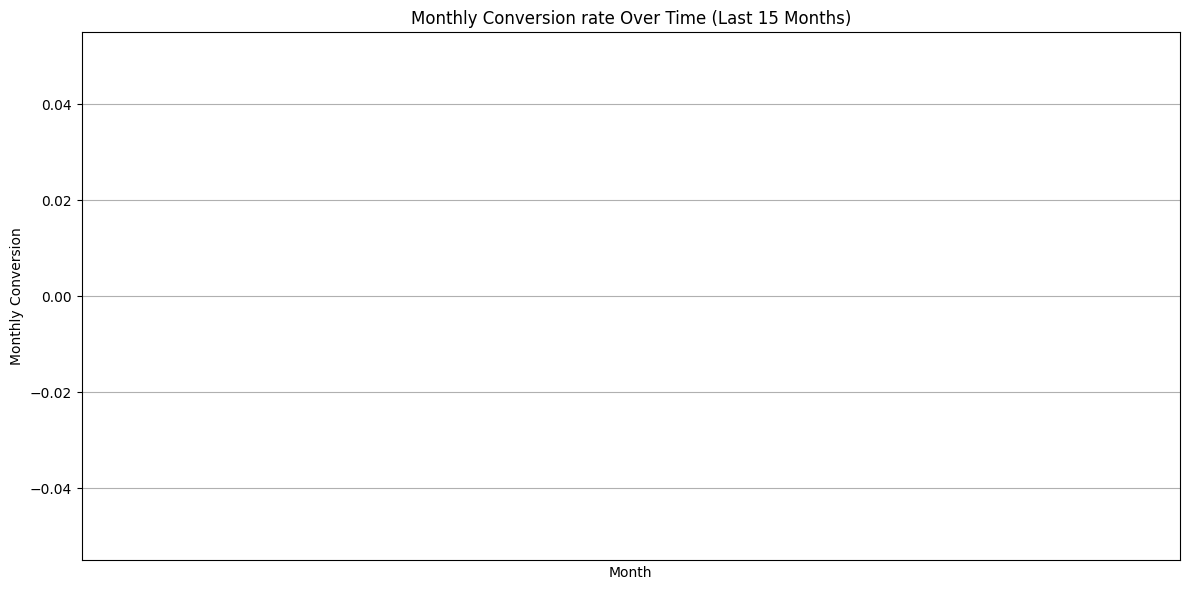

In [88]:
df = pd.DataFrame(list(sorted_result.items()), columns=['Month', 'Decimal'])
df['Month'] = pd.to_datetime(df['Month'])
df = df.sort_values(by='Month')
df = df[-16:-1]
df['Decimal'] = df['Decimal'] * 100

plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['Decimal'], marker='o', linestyle='-', color='b')
plt.title('Monthly Conversion rate Over Time (Last 15 Months)')
plt.xlabel('Month')
plt.ylabel('Monthly Conversion')
plt.xticks(df['Month'], rotation=45, ha='right')  # Set x-axis ticks to include all weeks
plt.grid(True)
plt.tight_layout()
plt.show()

# Fixed Seasonality

In [95]:
festivals = {
  "Diwali": "2022-10-24",
  "Holi": "2022-03-18",
  "Ganesh Chaturthi": "2022-08-31",
  "Dussehra": "2022-10-05",
  "Independence Day": "2022-08-15",
  "Republic Day": "2022-01-26",
  "Gandhi Jayanti": "2022-10-02",
  "Christmas Day": "2022-12-25",
  "New Year's Day": "2022-01-01"
}

In [96]:
def seasonality(df):
    m = Prophet(weekly_seasonality = True, yearly_seasonality = True, seasonality_mode="multiplicative")
    m.add_seasonality(name='monthly', period=30.5, fourier_order=10)
    m.fit(df)
    future = m.make_future_dataframe(periods=1825)
    forecast = m.predict(future)
    fig = m.plot_components(forecast)

    last_date = df['ds'].max()
    forecast['date'] = pd.to_datetime(forecast['ds'])
    previous_week_end = last_date - pd.DateOffset(weeks=1)
    previous_week_start = last_date - pd.DateOffset(weeks=1, days=6)
    previous_week_data = forecast[(forecast['date'] >= previous_week_start) & (forecast['date'] <= previous_week_end)]
    previous_week_avg = previous_week_data['yhat'].mean()
    previous_week_dates = f"{previous_week_start} - {previous_week_end}"

    forecast['date'] = pd.to_datetime(forecast['ds'])
    next_week_start = last_date + pd.DateOffset(weeks=1)
    next_week_end = last_date + pd.DateOffset(weeks=1, days=6)
    next_week_data = forecast[(forecast['date'] >= next_week_start) & (forecast['date'] <= next_week_end)]
    next_week_avg = next_week_data['yhat'].mean()
    next_week_dates = f"{next_week_start} - {next_week_end}"
    return previous_week_avg, next_week_avg, previous_week_dates, next_week_dates, forecast[['ds', 'yhat']]

def next_holiday_sales_pred(df, forecast, param):
    festival_name, festival_week_prediction, seasonality_impact = [], [], []
    flag = 0
    if "Ratio" in param or "Rate" in param  or param == "AOV" or param == "ASP" or "per" in param:
      flag = 1
    for i in range (4):
        festival = upcoming_festivals[i][0]
        festival_date = upcoming_festivals[i][1]
        festival_week_start = festival_date - timedelta(days = 3)
        festival_week_start = datetime.combine(festival_week_start, datetime.min.time())
        festival_week_end = festival_date + timedelta(days = 3)
        festival_week_end = datetime.combine(festival_week_end, datetime.min.time())
        festival_last_week_start = festival_date - timedelta(days = 10)
        festival_last_week_start = datetime.combine(festival_last_week_start, datetime.min.time())
        prediction_festival_last_week_data =  forecast[(forecast['ds'] >= festival_last_week_start) & (forecast['ds'] < festival_week_start)]
        prediction_festival_week_data =  forecast[(forecast['ds'] >= festival_week_start) & (forecast['ds'] < festival_week_end)]
        if flag == 1:
            prediction_festival_week = float(format(np.mean(prediction_festival_week_data['yhat'])))
            prediction_festival_last_week = float(format(np.mean(prediction_festival_last_week_data['yhat'])))
        else:
            prediction_festival_week = float(format(math.ceil(sum(prediction_festival_week_data['yhat']))))
            prediction_festival_last_week = float(format(math.ceil(sum(prediction_festival_last_week_data['yhat']))))

        if "Ratio" in param and prediction_festival_week >= 1 and prediction_festival_last_week >= 1:
            festival = upcoming_festivals[i][0]
            festival_date = festivals[festival]
            festival_date = datetime.strptime(festival_date, "%Y-%m-%d").date()
            festival_week_start = festival_date - timedelta(days = 3)
            festival_week_start = datetime.combine(festival_week_start, datetime.min.time())
            festival_week_end = festival_date + timedelta(days = 3)
            festival_week_end = datetime.combine(festival_week_end, datetime.min.time())
            festival_last_week_start = festival_date - timedelta(days = 10)
            festival_last_week_start = datetime.combine(festival_last_week_start, datetime.min.time())
            prediction_festival_last_week_data =  df[(df['ds'] >= festival_last_week_start) & (df['ds'] < festival_week_start)]
            prediction_festival_week_data =  df[(df['ds'] >= festival_week_start) & (df['ds'] < festival_week_end)]
            prediction_festival_week = float(format(np.mean(prediction_festival_week_data['y'])))
            prediction_festival_last_week = float(format(np.mean(prediction_festival_last_week_data['y'])))

        if "Rate" in param and prediction_festival_week >= 100 and prediction_festival_last_week >= 100:
            festival = upcoming_festivals[i][0]
            festival_date = festivals[festival]
            festival_date = datetime.strptime(festival_date, "%Y-%m-%d").date()
            festival_week_start = festival_date - timedelta(days = 3)
            festival_week_start = datetime.combine(festival_week_start, datetime.min.time())
            festival_week_end = festival_date + timedelta(days = 3)
            festival_week_end = datetime.combine(festival_week_end, datetime.min.time())
            festival_last_week_start = festival_date - timedelta(days = 10)
            festival_last_week_start = datetime.combine(festival_last_week_start, datetime.min.time())
            prediction_festival_last_week_data =  df[(df['ds'] >= festival_last_week_start) & (df['ds'] < festival_week_start)]
            prediction_festival_week_data =  df[(df['ds'] >= festival_week_start) & (df['ds'] < festival_week_end)]
            prediction_festival_week = float(format(np.mean(prediction_festival_week_data['y'])))
            prediction_festival_last_week = float(format(np.mean(prediction_festival_last_week_data['y'])))
        if prediction_festival_last_week != 0:
          WoW_relation = ((prediction_festival_week - prediction_festival_last_week) * 100) / prediction_festival_last_week
        else:
          WoW_relation = 100
        WoW_relation = round(WoW_relation, 2)
        festival_name.append(festival)
        festival_week_prediction.append(round(prediction_festival_week, 2))
        seasonality_impact.append(WoW_relation)
    df = pd.DataFrame({"Upcoming Event": festival_name, f"Predicted Value of {param} for the Festival Week": festival_week_prediction, "Seasonality Impact (Week on Week)": seasonality_impact})
    return df

def holiday(df, festivals, parameter, start=-1, end=-1):
    if start == -1 and end == -1:
        df['Order_Date'] = pd.to_datetime(df['Order_Date'])
        end = df['Order_Date'].max()
        start = df["OrdeR_Date"].min()
    start = datetime.strptime("start", "%Y-%m-%d")
    end = datetime.strptime("end", "%Y-%m-%d")
    start_year = start.year
    end_year = end.year

    years = [x for x in range (start_year, end_year+1)]
    updated_festivals = {}
    for year in years:
      for festival, date_str in festivals.items():
          date_object = datetime.strptime(date_str, "%Y-%m-%d")
          updated_date_str = f"{year:04d}-{date_object.month:02d}-{date_object.day:02d}"
          updated_festivals[f"{festival}_{year}"] = updated_date_str

    filtered_festivals = {}

    for festival, date_str in updated_festivals.items():
        festival_date = datetime.strptime(date_str, '%Y-%m-%d')
        if start <= festival_date <= end:
            filtered_festivals[festival] = date_str

In [98]:
import logging
logging.captureWarnings(True)
parameter = "Order_Counts"
df = y2[["Order_Date", parameter]]
df_prophet = df.copy()
df_prophet.columns = ["ds", "y"]

# prev_week_avg, next_week_avg, last_week_duration, next_week_duration, forecast = seasonality(df_prophet)
# festival_forecast = next_holiday_sales_pred(df, forecast, parameter)
print("="*140)